In [74]:
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('../data/processed/character_deaths.csv')

with open('../missing_metadata_movie_ids.txt') as f:
    missing_ids = set(map(int, f.read().splitlines()))

df['has_listed_characters'] = ~df['movie_id'].isin(missing_ids)
df.head()

,movie_id,character_name,dies,has_listed_characters
0,19783345,Dale,False,False
1,19783345,Jean,False,False
2,19783345,Mario,False,False
3,35777727,Karat,False,False
4,35777727,Sludge,False,False


In [76]:
print(f"Number of movies: {len(df['movie_id'].unique())}")

Number of movies: 976


In [77]:
list_present = df[df['has_listed_characters']]['dies'].mean()
list_absent = df[~df['has_listed_characters']]['dies'].mean()
print(f"Death rate for movies with listed characters: {list_present:.2%}")
print(f"Death rate for other movies: {list_absent:.2%}")

Death rate for movies with listed characters: 15.98%
Death rate for other movies: 21.66%


In [78]:
characters_per_movie = df.groupby('movie_id')['character_name'].count()
print(characters_per_movie.describe())

count    976.000000
mean       5.433402
std        4.304282
min        0.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       55.000000
Name: character_name, dtype: float64


In [79]:
death_rate_per_movie = df.groupby('movie_id')['dies'].mean()
print(death_rate_per_movie.describe())

count    976.000000
mean       0.212160
std        0.314995
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: dies, dtype: float64


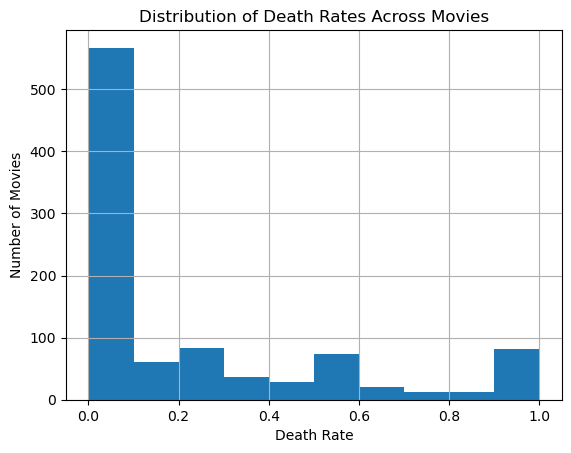

In [81]:
death_rate_per_movie.hist(bins=10)
plt.xlabel('Death Rate')
plt.ylabel('Number of Movies')
plt.title('Distribution of Death Rates Across Movies')
plt.show()

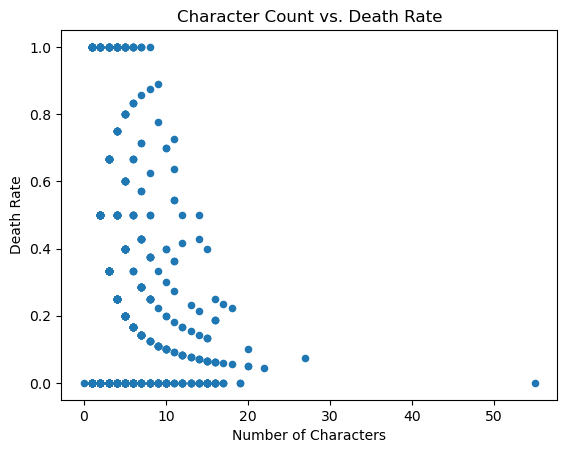

In [82]:
scatter_data = df.groupby('movie_id').agg({'character_name': 'count', 'dies': 'mean'})
scatter_data.plot.scatter(x='character_name', y='dies')
plt.xlabel('Number of Characters')
plt.ylabel('Death Rate')
plt.title('Character Count vs. Death Rate')
plt.show()

In [83]:
from scipy.stats import ttest_ind

listed_dies = df[df['has_listed_characters']]['dies'].astype(int)
unlisted_dies = df[~df['has_listed_characters']]['dies'].astype(int)

t_stat, p_value = ttest_ind(listed_dies, unlisted_dies, equal_var=False)
print(f"T-statistic: {t_stat},\nP-value: {p_value}")

T-statistic: -4.9408152541508725,
P-value: 8.167487999867342e-07


Based on the p-value, the data for the movies with no listed characters is likely less reliable.

Hypothesis: if a list of names is not given, the LLM sometimes only extracts the names of characters who die. 

In [115]:
outlier_movie_ids = death_rate_per_movie[death_rate_per_movie == 1.0].index
outlier_movie_ids

Index([    5313,    39311,   156628,   238810,   451791,   545615,   555857,
         629209,   642867,   844331,   905533,   983731,  1022323,  1253851,
        1413739,  1894535,  1958425,  2276474,  2493307,  2918585,  3614997,
        3616144,  3718428,  3827920,  3868432,  4021176,  4410476,  4453753,
        4714316,  4738713,  4780536,  5140171,  5257549,  5291288,  5292154,
        6407830,  6446071,  6553805,  6708645,  6743019,  7154010,  8351040,
        8437284,  8447974,  8675614,  8972250,  9144986,  9416151, 10198223,
       10540961, 10575225, 10943915, 11450530, 12152200, 12556054, 13093495,
       13922038, 14187517, 15916538, 17208834, 17228796, 18499953, 18950355,
       20489956, 20579732, 21624213, 23950601, 24552424, 25085163, 25445821,
       27398409, 28823872, 28946385, 29195939, 30116603, 30237779, 30283732,
       31158330, 31329569, 32267636, 34587102],
      dtype='int64', name='movie_id')

In [116]:
outlier_movies_with_listed_characters = df[df['movie_id'].isin(outlier_movie_ids) & df['has_listed_characters']]['movie_id']
outlier_movies_with_no_listed_characters = df[df['movie_id'].isin(outlier_movie_ids) & ~df['has_listed_characters']]['movie_id']

print("Outlier movies with listed characters:", len(outlier_movies_with_listed_characters))
print("Outlier movies without listed characters:", len(outlier_movies_with_no_listed_characters))

Outlier movies with listed characters: 142
Outlier movies without listed characters: 121


In [117]:
shortest_weird_movie = None
shortest_weird_movie_id = None

for weird_id in outlier_movies_with_listed_characters:
    with open(f'../data/interim/plot_summaries_{weird_id}.txt', 'r') as f:
        weird_movie = f.read()
        if shortest_weird_movie is not None and len(weird_movie) < len(shortest_weird_movie):
            shortest_weird_movie = weird_movie
            shortest_weird_movie_id = weird_id
        elif shortest_weird_movie is None:
            shortest_weird_movie = weird_movie
            shortest_weird_movie_id = weird_id

print(shortest_weird_movie_id)
print(shortest_weird_movie)

18950355
The film was based on actual events regarding a young swimming coach having an affair with an older woman until her husband is forced to end it. This resulted in a chain of reactions from photocopying of love letters leading up to her murder.



In [118]:
df[df['movie_id'] == 18950355]

,movie_id,character_name,dies,has_listed_characters,character_name_lower
2029,18950355,Vivian Conrad,True,True,vivian conrad


The summary had no names, so the LLM assumes the only woman in the summary is Vivian.

In [88]:
metadata = pd.read_csv(
    "../data/raw/character.metadata.tsv",
    sep="\t",
    header=None,
    names=[
        "wikipedia_movie_id", "freebase_movie_id", "movie_release_date", 
        "character_name", "actor_dob", "actor_gender", "actor_height",
        "actor_ethnicity", "actor_name", "actor_age_at_release",
        "freebase_char_actor_map_id", "freebase_character_id", "freebase_actor_id"
    ]
)

In [89]:
df['character_name_lower'] = df['character_name'].str.lower()
metadata['character_name_lower'] = metadata['character_name'].str.lower()

In [90]:
exact_matches = df.merge(
    metadata[['wikipedia_movie_id', 'character_name_lower']],
    left_on=['movie_id', 'character_name_lower'],
    right_on=['wikipedia_movie_id', 'character_name_lower'],
    how='inner'
)

unmatched_characters = df.merge(
    metadata[['wikipedia_movie_id', 'character_name_lower']],
    left_on=['movie_id', 'character_name_lower'],
    right_on=['wikipedia_movie_id', 'character_name_lower'],
    how='left',
    indicator=True
)
unmatched_characters = unmatched_characters[unmatched_characters['_merge'] == 'left_only']
unmatched_characters = unmatched_characters.drop(columns=['_merge', 'wikipedia_movie_id'])

In [113]:
match_numbers = {
    "Count": [
        len(exact_matches),
        len(exact_matches[exact_matches['has_listed_characters']]),
        len(exact_matches[~exact_matches['has_listed_characters']]),
        len(unmatched_characters),
        len(unmatched_characters[unmatched_characters['has_listed_characters']]),
        len(unmatched_characters[~unmatched_characters['has_listed_characters']])
    ]
}

match_numbers_index = pd.MultiIndex.from_tuples([
    ("Matched", "Total"),
    ("Matched", "Listed Characters"),
    ("Matched", "No Listed Characters"),
    ("Unmatched", "Total"),
    ("Unmatched", "Listed Characters"),
    ("Unmatched", "No Listed Characters")
], names=["Match Type", "Movie Type"])


pd.DataFrame(match_numbers, index=match_numbers_index)

Count
Match Type Movie Type                 
Matched    Total                  2790
           Listed Characters      2783
           No Listed Characters      7
Unmatched  Total                  2559
           Listed Characters       755
           No Listed Characters   1804

We can find more matches with fuzzy matching

In [37]:
# !pip install rapidfuzz

In [42]:
from collections import defaultdict

metadata_by_movie = defaultdict(list)

for _, row in metadata.iterrows():
    metadata_by_movie[row['wikipedia_movie_id']].append(row['character_name_lower'])

In [102]:
from rapidfuzz import process

def find_closest_match(row):
    movie_id = row['movie_id']
    character_name = row['character_name_lower']
    
    if movie_id in metadata_by_movie:
        choices = metadata_by_movie[movie_id]
        match = process.extractOne(character_name, choices)
        if match:
            return match[0], match[1]
    return None, None

In [103]:
unmatched_characters[['closest_match', 'match_score']] = unmatched_characters.apply(
    find_closest_match, axis=1, result_type='expand'
)

fuzzy_matches = unmatched_characters[unmatched_characters['match_score'] >= 90]
remaining_unmatched = unmatched_characters[unmatched_characters['match_score'] < 90]

In [104]:
fuzzy_matches

,movie_id,character_name,dies,has_listed_characters,character_name_lower,closest_match,match_score
92,27160128,Gopi,False,True,gopi,gopinathan,90.000000
170,24467898,Mrinalini Mitra,True,True,mrinalini mitra,aged mrinalini mitra,95.000000
229,277667,Greg Phillipe,True,True,greg phillipe,greg phillippe,96.296296
328,26761990,Suzy Brack,False,True,suzy brack,suzy brack & the new jack lords member,90.000000
329,26761990,The New Jack Lords Member,False,True,the new jack lords member,suzy brack & the new jack lords member,90.000000
...,...,...,...,...,...,...,...
4809,2529009,Bobby Earl Ferguson,True,True,bobby earl ferguson,bobby earl,90.000000
5145,31882143,Shwetha Rajendran,False,True,shwetha rajendran,rajendran,90.000000
5158,15065852,Polly Barlow's aunt,True,True,polly barlow's aunt,polly barlow,90.000000
5262,726161,Colonel Geoffery Brydon,False,True,colonel geoffery brydon,colonel geofferey brydon,97.872340


90 seems to be a good threshold for fuzzy matching. We are able to extract 69 additional matches out of 2559 names without exact matches.